Notebook illustrating network design calculations. 

The goal is to objectively find the network of observations that is optimal in a chosen measure. For example, suppose I want to measure the average surface temperature of a remote area. I could site the instruments in any of 3000 locations, but I can only afford to place 3 in the field. Where should I go?

Originator:
G. J. Hakim, University of Washington, 18 June 2020

This notebook uses:

1. instrumental temperature data for a chosen dataset (e.g. HadCRU)
2. identity observations for all grid points
3. in-sample verification, including randomly chosen networks
4. the "lite" version of the [Last Millennium Reanalysis](https://github.com/modons/LMR) (LMR) code

${\bf Theory}$:

Measure the performance of the observing network with a functional, $J$, on the state, ${\bf x}$. We assume that $J$ is linearly related to ${\bf x}$, and Gaussian distributed. Let {} be an expectation.

$$
J({\bf x}) \sim N(0,\sigma) \hskip 3em {\bf x} \sim N(0,{\bf B}),
$$

$$
\delta J \approx \frac{\partial J}{\partial {\bf x}}^T \delta {\bf x} \hskip 1em (1)
$$

$$
\{\delta J \delta J^T\} \approx \frac{\partial J}{\partial {\bf x}}^T {\bf B} \frac{\partial J}{\partial {\bf x}} \approx \sigma
$$

Taking an observation changes $\sigma$ and ${\bf B}$:

$$
\delta\sigma \approx \frac{\partial J}{\partial {\bf x}}^T ({\bf B}' - {\bf B})\frac{\partial J}{\partial {\bf x}}
$$

$$
{\bf B}' - {\bf B} = -{\bf K H B} \hskip 1em (2)
$$

${\bf K}$ is the Kalman gain matrix, and ${\bf H}$ is the observation operator. From (1):

$$
\{\delta J, \delta {\bf x}^T\} = \frac{\partial J}{\partial {\bf x}}^T {\bf B} 
$$

So that

$$
\delta\sigma \approx - \{\delta J, ({\bf H}\delta {\bf x})^T \} [{\bf H B H}^T + {\bf R}]^{-1}  \{\delta J, ({\bf H}\delta {\bf x})^T \}^T
$$

For a single observation, $y_e = {\bf H}\delta {\bf x}$, with error variance $r$:

$$
\delta\sigma \approx - cov(J,y_e)^2 / E \hskip 1em (3)
$$

$$
E = var(y_e) + r
$$

Algorithm:
1. measure all possible observations affect on $\delta\sigma$ using (3).
2. Pick the observation with the most negative $\delta\sigma$.
3. update $J$ and ${\bf B}$ using (2)
4. Return to 1. until $\delta\sigma$ is not different from noise.

References:
* Hakim et al. (2020): https://doi.org/10.1175/MWR-D-19-0103.1
* Huntley and Hakim (2010): https://link.springer.com/article/10.1007/s00382-009-0714-5
* Mauger et al. (2013): https://www.researchgate.net/profile/Guillaume_Mauger/publication/258786888_Optimal_design_of_a_climatological_network_beyond_practical_considerations/links/56faf52108ae8239f6dad829.pdf
* Ancell and Hakim (2007): https://doi.org/10.1175/2007MWR1904.1
* Torn and Hakim (2008): https://doi.org/10.1175/2007MWR2132.1


In [1]:
# set parameters here

# specify the observation error variance
obvar = 0.1

# number of observations in the observing network
nobs = 10

# chose a performance optimization metric (see compute_J for options)
Jname = 'gm'
#Jname = 'nhm'
#Jname = 'shm'
#Jname = 'noam'

# covariance localization length scale (km); over-rides configuration
#loc_rad = 1e3
loc_rad = 10e3

# configuration file
cfile = './config/config.yml.netdesign'

# default figure size (inches)
figsize = 6 

In [2]:
import sys,os,copy
sys.path.append("/Users/hakim/gitwork/LMR_python3")

In [3]:
import numpy as np
import numpy.ma as ma
import random
from collections import OrderedDict 
import LMR_lite_utils as LMRlite
import LMR_config
import LMR_utils

Loading information from datasets.yml
Loading information from grid_def.yml


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import importlib

In [5]:
import cartopy.crs as ccrs
import cartopy.feature
    

In [6]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# use this when testing changes to external packages
#import importlib
#importlib.reload(LMRlite)
importlib.reload(LMR_utils)

<module 'LMR_utils' from '/Users/hakim/gitwork/LMR_python3/LMR_utils.py'>

In [8]:
# set default figure size
plt.rcParams["figure.figsize"] = [figsize,figsize]

### convenience functions

In [9]:
def compute_J(X,Jcho,grid):
    """
    compute the performance metric for a sample (ensemble). J is a functional: it maps 
    a state vector onto a scalar. 
    
    input:
    * X ~ Ndof x Nsamp : an ensemble state vector
    * grid: grid object containing lat lon grid info
    * Jcho : string selector for the metric. current options
        - 'gm': global mean 
        - 'nhm': northern hemisphere mean
        - 'shm': southern hemisphere mean
    output:
    * J ~ Nsamp
    
    Nsamp: sample (ensemble) size
    Ndof: dimension of the state vector
    """
    
    nsamp = X.shape[1]
    if Jcho == 'gm' or Jcho == 'nhm' or Jcho == 'shm':
        gm,nhm,shm = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(X,[grid.nlat,grid.nlon,nsamp]),-1,0),grid.lat[:,0])
        if Jcho == 'gm':
            J = gm
        elif Jcho == 'nhm':
            J = nhm
        else:
            J = shm
            
    # as defined in LMR_utils.PAGES2K_regional_means
    if Jcho == 'noam' or Jcho == 'soam' or Jcho == 'arctic':
        rnames,rm = LMR_utils.PAGES2K_regional_means(np.moveaxis(np.reshape(X,[grid.nlat,grid.nlon,nsamp]),-1,0),grid.lat,grid.lon)
        if Jcho == 'noam':
            J = rm[9]
        if Jcho == 'soam':
            J = rm[10]
        if Jcho == 'arctic':
            J = rm[6]

    return J

In [10]:
def ob_impact(J,Hx,oberr):
    """
    compute vectorized observation impact given:
    * J: cost function/performance metric ~ 1 x Nsamp
    * Hx: potential observation estimates ~ Ny x Nsamp 
    * oberr: observation error variance ~ Ny x 1
    Nsamp: sample dimension
    Ny: number of potential observations
    returns: 
    * obimp ~ Ny x 1
    """
    Nsamp = J.shape[0]
    covJHdx = np.dot(J,Hx.T)/(Nsamp-1)
    varHdx = np.diag(np.dot(Hx,Hx.T)/(Nsamp-1))
    obimp = covJHdx*covJHdx/(varHdx + oberr)
    return obimp

In [11]:
def make_Xcoord_object(grid,addJ=False):
    # convenience function to make an object for LMR_DA serial solver
    if addJ:
        # add the scalar metric to the state vector
        nx = grid.nlat*grid.nlon+1
    else:
        nx = grid.nlat*grid.nlon
        
    X_coords = LMRlite.Grid()
    X_coords.coords = np.zeros([nx,2])
    if addJ:
        X_coords.coords[:-1,0] = np.reshape(grid.lat,nx-1)
        X_coords.coords[:-1,1] = np.reshape(grid.lon,nx-1)
        # dummy lat,lon values for J
        X_coords.coords[-1,:] = [0,0]
    else:
        X_coords.coords[:,0] = np.reshape(grid.lat,nx)
        X_coords.coords[:,1] = np.reshape(grid.lon,nx)
        
    X_coords.trunc_state_info = {}
    X_coords.trunc_state_info['state'] = {'pos':[0,grid.nlat*grid.nlon],'spacecoords':('lat','lon')}
    X_coords.trunc_state_info['J'] = {'pos':[grid.nlat*grid.nlon,grid.nlat*grid.nlon+1],'spacecoords':(None)}

    return X_coords

In [12]:
def ob_impact_update(cfg,J,Hx,ob_index,grid,oberr,verbose=False):
    """
    update the observation estimates and the metric given:
    * cfg: the LMR configuration object
    * J: the performance metric ~ 1 x Nsamp
    * Hx: the observation estimates ~ Ny x Nsamp
    * ob_index: the index of the chosen observation in Hx
    * grid: LMR_lite grid object
    * oberr: the error vector for all observations
    """

    # sample (ensemble) size
    Nsamp = J.shape[0]

    # set up all of the coordinate info that the LMR_DA routine needs
    
    X_coords = make_Xcoord_object(grid,addJ=True)
    Ye_coords = np.zeros([1,2])
    Ye_coords[0,:] = X_coords.coords[ob_index,:]

    # dummy value for the "observation" (in theory it is not known)
    Y = [10]
    # apppended state, with metric attached
    Xb = np.append(Hx,J[np.newaxis],axis=0)
    Ye = np.zeros([1,Nsamp])
    Ye[0,:] = Hx[ob_index,:]
    R = [oberr[ob_index]]
    xam,Xap = LMRlite.Kalman_ESRF(cfg,Y,R,Ye,Xb,X_coords,Ye_coords,verbose=verbose)

    J_new = Xap[-1,:]
    Hx_new = Xap[0:-1]

    # xam is returned only to see the spatial pattern of the increment
    return xam[:-1],J_new,Hx_new

In [13]:
print('loading configuration...')
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg,cfg_dict = LMRlite.load_config(yaml_file)

loading configuration...
Checking configuration ... 
OK!


In [14]:
# fetch information from datasets.yml and attach to the cfg
dataset_info = LMR_config._DataInfo.data
cfg.info = dataset_info
# insure the localization is set correctly to the value specified here
cfg.core.loc_rad = loc_rad


In [15]:
# load instrumental temperature datasets
analysis_data,analysis_time,analysis_lat,analysis_lon = LMRlite.load_analyses(cfg,full_field=True)

loading annual-mean data...
loading GISTEMP...
loading  gistemp1200_ERSSTv5.nc
loading HadCRUT...
loading  HadCRUT.4.6.0.0.median.nc
loading BEST...
loading  Land_and_Ocean_LatLong1_28March2019.nc
loading MLOST...
loading  MLOST_air.mon.anom_V3.5.4.nc
returning spatial fields...


In [16]:
print(analysis_data.keys())

dict_keys(['GIS', 'CRU', 'BE', 'MLOST'])


In [17]:
# pick a dataset and initialize variables
dset = 'GIS'
print(cfg.prior.esmpy_grid_def)
target_grid = cfg.prior.esmpy_grid_def
nyears = analysis_data['GIS'].shape[0]
nlat_orig = analysis_lat[dset].shape[0]
nlon_orig = analysis_lon[dset].shape[0]
lon_2d_orig, lat_2d_orig = np.meshgrid(analysis_lon[dset],analysis_lat[dset])
tmp = np.reshape(analysis_data[dset],[nyears,nlat_orig*nlon_orig])
# this array is space x years
var_array_orig = tmp.T
# 6/17/2020 this version applies to the original coordinates
# vector versions of lat and lon to match the data array (useful when sorting impact results)
#lat_2d_vec = np.reshape(lat_2d,[nlat*nlon])
#lon_2d_vec = np.reshape(lon_2d,[nlat*nlon])

{'nlat': 45, 'nlon': 72, 'include_poles': False}


In [18]:
# regrid the data to the grid specified in the configuration
nlat = target_grid['nlat']
nlon = target_grid['nlon']
[var_array,lat,lon] = LMR_utils.regrid_esmpy(target_grid['nlat'],
                                                   target_grid['nlon'],
                                                   nyears,
                                                   var_array_orig,
                                                   lat_2d_orig,
                                                   lon_2d_orig,
                                                   nlat_orig,
                                                   nlon_orig)

In [19]:
# vector versions of lat and lon to match the data array (useful when sorting impact results)
lat_2d_vec = np.reshape(lat,[nlat*nlon])
lon_2d_vec = np.reshape(lon,[nlat*nlon])

In [20]:
# make covenience gridding objects
grid = LMRlite.Grid()
grid.lat = lat
grid.lon = lon
grid.nlat = nlat
grid.nlon = nlon

grid_orig = LMRlite.Grid()
grid_orig.lat = lat_2d_orig
grid_orig.lon = lon_2d_orig
grid_orig.nlat = nlat_orig
grid_orig.nlon = nlon_orig

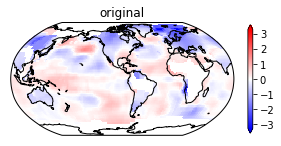

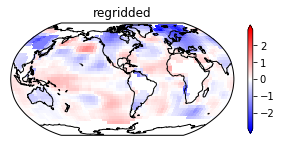

(90, 180)
(45, 72)


In [21]:
# check the regrid with some plots..
pdata = np.reshape(var_array_orig[:,1],[grid_orig.nlat,grid_orig.nlon])
LMRlite.make_plot(pdata,grid_orig,figsize=5,title='original')
pdata2 = np.reshape(var_array[:,1],[grid.nlat,grid.nlon])
LMRlite.make_plot(pdata2,grid,figsize=5,title='regridded')
print(pdata.shape)
print(pdata2.shape)

In [22]:
# original grid
gm_old,nhm_old,shm_old = LMR_utils.global_hemispheric_means(analysis_data[dset],analysis_lat[dset])

# regridded data
gm,nhm,shm = LMR_utils.global_hemispheric_means(np.reshape(var_array,[nlat,nlon,nyears]).T,lat[0])


0.24808327777133743


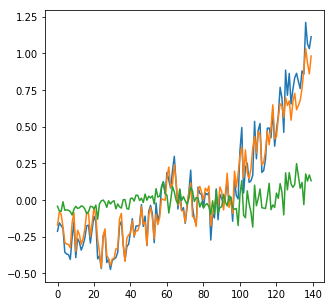

In [23]:
# plot comparing the original grid GMT vs. regrid
print(np.max(np.abs(gm-gm_old)))
plt.plot(gm)
plt.plot(gm_old)
plt.plot(gm-gm_old)

### optimal network calculation
* assumes identity observations with the same error variance
* one can fancy this up if needed
* compute dJ for all possible observations
* first, find the one most important observation (largest -dJ)
* second, compute a network by serially repeating the calculation

In [24]:
# define the optimization metric, J
J = compute_J(var_array,Jname,grid)

In [25]:
# test single points here (can add this to compute_J later)
# this will over-write J determined from the previous block
single_ob = False
#single_ob = True

if single_ob:
    pt = 2150
    print('lat=',lat_2d_vec[pt])
    print('lon=',lon_2d_vec[pt])
    J = var_array[pt,:]

    # spatial one-point correlation map
    Jcs = np.zeros(nlat*nlon)
    for m in range(nlat*nlon):
        Jcorr = ma.corrcoef(ma.masked_invalid(J),ma.masked_invalid(var_array[m,:]))
        #print(Jcorr)
        Jcs[m] = Jcorr[0,1]

    # spatial anomaly for the chosen observation (scaling is arbitrary)
    pdata = np.reshape(Jcs,[grid.nlat,grid.nlon])
    LMRlite.make_plot(pdata,grid,figsize=5,vmin=0.5)


In [26]:
# observation error variance
oberr = obvar*np.ones(grid.nlat*grid.nlon)

# impact of all observations (dJ)
obimp = ob_impact(J,var_array,oberr)

# LMD DA coords object has ordered lat,lon pairs
X_coords = make_Xcoord_object(grid)

max error in sorted impact =  0.0


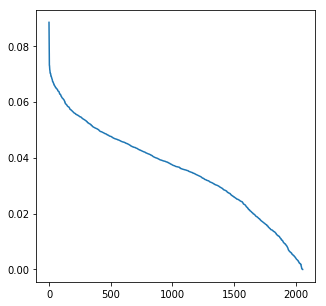

In [28]:
# sort and plot the results
simp = -np.sort(-obimp)
plt.plot(simp)
# use argsort so we have the indices too. check results...
check = obimp[np.argsort(-obimp)]
print('max error in sorted impact = ',np.nanmax(np.abs(simp-check)))


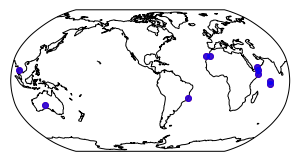

In [29]:
# find top n sites in lat/lon ignoring nan, and make a map
topsites = 10
sinds = np.argsort(-obimp)

latplot = X_coords.coords[sinds[0:topsites]][:,0]
lonplot = X_coords.coords[sinds[0:topsites]][:,1]
# check
latplot2 = lat_2d_vec[sinds[0:topsites]]
lonplot2 = lon_2d_vec[sinds[0:topsites]]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-90.))
alpha = 0.75
sym ='o'
c = 'r'
msize = 100
ax.plot(lonplot,latplot,'or',alpha=alpha,transform=ccrs.PlateCarree(),)
ax.plot(lonplot2,latplot2,'ob',alpha=alpha,transform=ccrs.PlateCarree(),)
ax.set_global()
ax.coastlines()


### update the prior and J with one chosen observation

In [30]:
# pick the location with the largest impact
xam,J_new,Xap = ob_impact_update(cfg,J,var_array,sinds[0],grid,oberr)

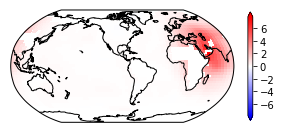

In [31]:
# spatial anomaly for the chosen observation (scaling is arbitrary)
pdata = np.reshape(xam,[grid.nlat,grid.nlon])
LMRlite.make_plot(pdata,grid,figsize=5)

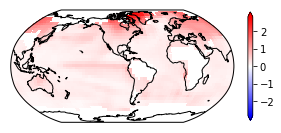

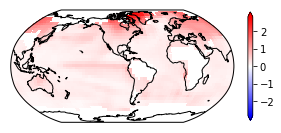

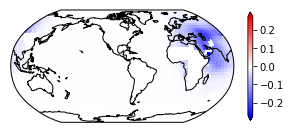

In [32]:
# plot the variance and the change in variance 
tvar = np.var(var_array,axis=1)
pdata = np.reshape(tvar,[grid.nlat,grid.nlon])
LMRlite.make_plot(pdata,grid,figsize=5)
tvar2 = np.var(Xap,axis=1)
pdata2 = np.reshape(tvar2,[grid.nlat,grid.nlon])
LMRlite.make_plot(pdata,grid,figsize=5)
LMRlite.make_plot(pdata2-pdata,grid,figsize=5)


### solve for a network serially, each ob conditional on previous


In [33]:
# parameter nobs is set at the top of the file in the parameter section
X = np.copy(var_array)
#J = compute_J(var_array,Jname,grid)

optobs = OrderedDict()
for ob in range(nobs):
    obimp = ob_impact(J,X,oberr)
    sinds = np.argsort(-obimp)
    _,J,X = ob_impact_update(cfg,J,X,sinds[0],grid,oberr,verbose=False)
    print(ob,sinds[0],obimp[sinds[0]],lat_2d_vec[sinds[0]],lon_2d_vec[sinds[0]])
    optobs[ob] = [sinds[0],obimp[sinds[0]],lat_2d_vec[sinds[0]],lon_2d_vec[sinds[0]]]

0 1882 0.0884085122567233 16.0 50.0
1 2158 0.020750165926023592 28.0 350.0
2 1106 0.006070460610293166 -28.0 130.0
3 2962 0.0022203748351219913 76.0 50.0
4 1424 0.0010494755775011975 -12.0 280.0
5 2627 0.0006527570576385114 56.0 175.0
6 2443 0.000413736356324385 44.0 335.0
7 1087 0.00033287593797491123 -28.0 35.0
8 2687 0.00022885608473363788 60.0 115.0
9 2407 0.00017387113114395206 44.0 155.0


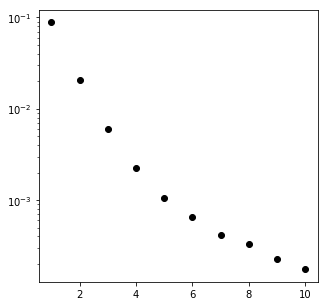

In [34]:
# ob impact as a function of ob number
for ob in optobs.keys():
    plt.semilogy(ob+1,optobs[ob][1],'ko')

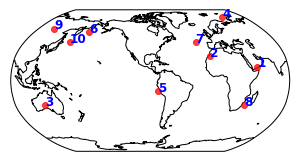

In [35]:
# map of the ordered ob locations
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-90.))
for ob in optobs.keys():
    # plot a number at the location:
    ax.text(optobs[ob][3],optobs[ob][2],ob+1,weight='bold',size='large',color='blue',transform=ccrs.PlateCarree(),)
    alpha = 0.75
    sym ='o'
    c = 'r'
    msize = 100
    ax.plot(optobs[ob][3],optobs[ob][2],'or',alpha=alpha,transform=ccrs.PlateCarree(),)
ax.set_global()
ax.coastlines()


### check the predictions with assimilation experiments

In [36]:
"""
first experiment: reconstruct all years and check error reduction
compared to a random network. then test in and out of sample results
"""

# perfect observations drawn from the optimal locations
obinds = []
for ob in optobs.keys():
    obinds.append(optobs[ob][0])
    
obs = var_array[obinds,:]
R = oberr[obinds]

# make coordinates for LMR_DA
X_coords = make_Xcoord_object(grid)
Ye_coords = X_coords.coords[obinds,:]

# prior ensemble
Xb = np.copy(var_array)
Ye = np.copy(obs)
R = oberr[obinds]
xam_save = np.zeros([grid.nlat*grid.nlon,nyears])
xam_save_rand = np.zeros([grid.nlat*grid.nlon,nyears])

# reconstruction for same prior every year
for year in range(nyears):
    print('working on year: ',year)
    Y = obs[:,year]
    xam,Xap = LMRlite.Kalman_ESRF(cfg,Y,R,Ye,Xb,X_coords,Ye_coords)
    xam_save[:,year] = xam
    

working on year:  0
working on year:  1
working on year:  2
working on year:  3
working on year:  4
working on year:  5
working on year:  6
working on year:  7
working on year:  8
working on year:  9
working on year:  10
working on year:  11
working on year:  12
working on year:  13
working on year:  14
working on year:  15
working on year:  16
working on year:  17
working on year:  18
working on year:  19
working on year:  20
working on year:  21
working on year:  22
working on year:  23
working on year:  24
working on year:  25
working on year:  26
working on year:  27
working on year:  28
working on year:  29
working on year:  30
working on year:  31
working on year:  32
working on year:  33
working on year:  34
working on year:  35
working on year:  36
working on year:  37
working on year:  38
working on year:  39
working on year:  40
working on year:  41
working on year:  42
working on year:  43
working on year:  44
working on year:  45
working on year:  46
working on year:  47
wo

In [37]:
# compute metric in the reconstructed data
J_recon = compute_J(xam_save,Jname,grid)

In [38]:
# repeat the calculation for random observing networks

# number of random networks
MCits = 10

Xb = np.copy(var_array)
Ye = np.copy(obs)
R = oberr[obinds]

J_MC = np.zeros([nyears,MCits])
for it in range(MCits):
    print('working on iteration: ',it)
    
    # random observation locations for this network
    randinds = np.random.randint(0,grid.nlat*grid.nlon,nobs)
    obs_rand = var_array[randinds,:]
    Ye_coords_rand = X_coords.coords[randinds,:]

    # store the spatial fields
    xam_save_rand = np.zeros([grid.nlat*grid.nlon,nyears])
    for year in range(nyears):
        # QC'd obs
        goodobs = np.isfinite(obs_rand[:,year])
        Y_rand = obs_rand[goodobs,year]
        Ye_coords_rand_QC = Ye_coords_rand[goodobs,:]
        R_QC = R[goodobs]
        Ye_QC = Ye[goodobs]
        xam,Xap = LMRlite.Kalman_ESRF(cfg,Y_rand,R_QC,Ye_QC,Xb,X_coords,Ye_coords_rand_QC)
        xam_save_rand[:,year] = xam
        
    # compute the metric and store for this iteration
    J_recon_rand = compute_J(xam_save_rand,Jname,grid)
    J_MC[:,it] = J_recon_rand

working on iteration:  0
working on iteration:  1
working on iteration:  2
working on iteration:  3
working on iteration:  4
working on iteration:  5
working on iteration:  6
working on iteration:  7
working on iteration:  8
working on iteration:  9


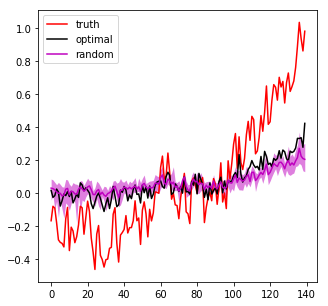

In [39]:
# plot truth, optimal, and random network
J_truth = compute_J(var_array,Jname,grid)

plt.plot(J_truth,'r-',label='truth')
plt.plot(J_recon,'k-',label='optimal')    
plt.plot(np.mean(J_MC,1),'m-',label='random')
plt.fill_between(range(nyears),np.max(J_MC,1),np.min(J_MC,1),alpha=0.5,color='m',linewidth=0)
plt.legend()

This small optimal network gets more signal than randomly chosen networks 

In [40]:
# now check the network prediction serially, one ob at a time
maxobs = 10
Jvar_mean = []
for k in range(maxobs):

    print('working on ',k)
    obinds = []
    for ob in optobs.keys():
        if ob <= k: obinds.append(optobs[ob][0])

    obs = var_array[obinds,:]
    R = oberr[obinds]

    # make coordinates for LMR_DA
    X_coords = make_Xcoord_object(grid)
    Ye_coords = X_coords.coords[obinds,:]

    # prior ensemble
    Xb = np.copy(var_array)
    Ye = np.copy(obs)
    R = oberr[obinds]
    xam_save = np.zeros([grid.nlat*grid.nlon,nyears])
    xam_save_ = np.zeros([grid.nlat*grid.nlon,nyears])

    # reconstruction for same prior every year
    Jvar = []
    for year in range(nyears):
        Y = obs[:,year]
        xam,Xap = LMRlite.Kalman_ESRF(cfg,Y,R,Ye,Xb,X_coords,Ye_coords)
        J_ens = compute_J(Xap,Jname,grid)
        # metric sample variance
        Jvar.append(np.var(J_ens,ddof=1))
        
    Jvar_mean.append(np.mean(Jvar))

working on  0
working on  1
working on  2
working on  3
working on  4
working on  5
working on  6
working on  7
working on  8
working on  9


Text(0.5,1,'predict (red) vs. actual (black) $\\delta$var(J)')

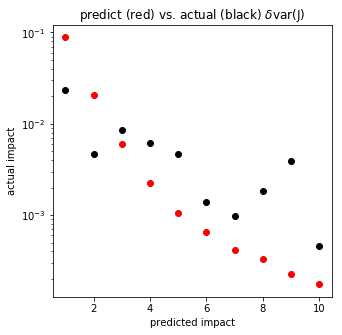

In [41]:
# plot results for \delta var(J)
for k in range(maxobs):
    if k == 0:
        # first one compares with unconditioned prior
        dJvar = -(Jvar_mean[k]-np.var(J_truth,ddof=1))
    else:
        dJvar = -(Jvar_mean[k]-Jvar_mean[k-1])
        
    plt.semilogy(k+1,optobs[k][1],'ro')
    plt.semilogy(k+1,dJvar,'ko')
    
xl = plt.xlim()
plt.xlabel('predicted impact')
plt.ylabel('actual impact')
plt.title('predict (red) vs. actual (black) $\delta$var(J)')

Text(0.5,1,'predict vs. actual $\\delta$var(J)')

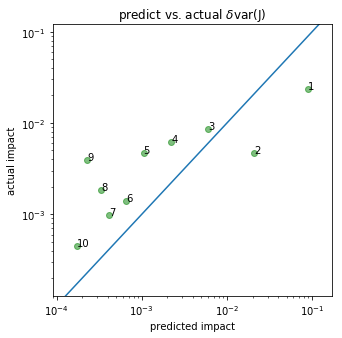

In [42]:
# compare prediction with actual impact
for k in range(maxobs):
    if k == 0:
        # first one compares with unconditioned prior
        dJvar = -(Jvar_mean[k]-np.var(J_truth,ddof=1))
    else:
        dJvar = -(Jvar_mean[k]-Jvar_mean[k-1])
    #print(optobs[k][1],dJvar)
    plt.loglog(optobs[k][1],dJvar,'go',alpha=0.5)
    plt.text(optobs[k][1],dJvar,k+1)
    
xl = plt.xlim()
plt.ylim(xl)
plt.plot(xl,xl)
plt.xlabel('predicted impact')
plt.ylabel('actual impact')
plt.title('predict vs. actual $\delta$var(J)')